In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline
import torch

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import os
import cv2
import numpy as np

In [3]:
#Gcloud path
# path_hr = Path('/home/jupyter/data/chest_xray/images')
# path_lr = Path('/home/jupyter/data/chest_xray/augment_data')

#Local path MMIV
path_hr = Path('/home/fredrikmathisen/Documents/data/chest_xray/images')
path_lr = Path('/home/fredrikmathisen/Documents/data/chest_xray/crappy')

torch.Size([3, 1670, 1820])


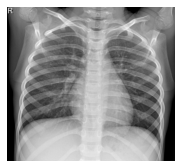

In [4]:
asda = open_image(path_hr/'IM-0401-0001.jpeg')
print(asda.data.shape)
asda.show()

In [5]:
def get_text_dimensions(text_string, font):
    
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return text_width, text_height

In [6]:
s = 'hei hei'
font = ImageFont.truetype('resource/arial.ttf', 20)
w,h = get_text_dimensions(s, font)
w

NameError: name 'ImageFont' is not defined

In [7]:
def get_fn(filename):
    fn = os.path.basename(os.path.normpath(filename))
    return fn

In [56]:
with open("coords.csv","a") as file:
                    filewriter = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    filewriter.writerow(['file_name', 'bbox', 'cat'])

In [57]:
import random, string
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import csv

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        font = ImageFont.truetype('resource/arial.ttf', 20)
        img = img.resize(img.size, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        names = []
        genders = ['M', 'F']
        with open(Path('resource/names.txt')) as f:
            names= list(f)
        name = str(random.choice(names)) + " " + str(random.choice(names))
        ssn = random.randint(10000000000, 99999999999)
        age = "Age: " + str(random.randint(1, 150))
        sex = "Sex: " + random.choice(genders)
#         data1 = str(random.randint(1, 9)) + "/" + str(9)
#         data2 = "IM #:"
#         data3 = "SE #:"
#         data4 = "WL: W:" + str(random.randint(0,360)) + "L: " + str(random.randint(0, 360))
        q = ''.join(random.choice(string.ascii_lowercase) for i in range(random.randint(1, 8)))
        ImageDraw.Draw(img).text((5,5), str(name), fill=(255,255,255), font=font) #first text
        ImageDraw.Draw(img).text((5,65), str(age), fill=(255,255,255), font=font) #second text
        ImageDraw.Draw(img).text((5,95), str(sex), fill=(255,255,255), font=font) #third text
        ImageDraw.Draw(img).text((5,140), str(ssn), fill=(255,255,255), font=font) # fourth text
        ImageDraw.Draw(img).text((w-100, 5), str(name), fill=(255,255,255), font=font) #name right text
        recompute_scale_factor=True
        
        name_w, name_h = get_text_dimensions(str(name), font)
        age_w, age_h = get_text_dimensions(str(age), font)
        sex_w, sex_h = get_text_dimensions(str(sex), font)
        ssn_w, ssn_h = get_text_dimensions(str(ssn), font)
        
        #y, x, h+y-1,w+x-1
        
        bbox_name1 = [5, 5, (name_h+5-1)*2, ((name_w+5-1)/2)+5]
        bbox_age = [65, 5, age_h+65-1, age_w+5-1]
        bbox_sex = [95, 5, sex_h+95-1, sex_w+5-1]
        bbox_ssn = [140, 5, ssn_h+140-1, ssn_w+5-1]
        bbox_name2 = [5, w-100, (name_h+5-1)*2, (name_w+(w-100)-1)]
        bboxes = [bbox_name1, bbox_age, bbox_sex, bbox_ssn, bbox_name2]
        
        with open("coords.csv","a") as file:
                    filewriter = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    filewriter.writerow([get_fn(fn), bboxes, ['','','','','']])
        
        
        img.save(dest)

In [40]:
from PIL import Image, ImageDraw, ImageFont
from random import randint

In [41]:
il = ImageList.from_folder(path_hr)

In [42]:
print(il)

ImageList (5856 items)
Image (3, 1110, 1276),Image (3, 1670, 1820),Image (3, 1608, 1902),Image (3, 656, 1064),Image (3, 736, 992)
Path: /home/fredrikmathisen/Documents/data/chest_xray/images


In [58]:
parallel(crappifier(path_lr, path_hr), il.items)

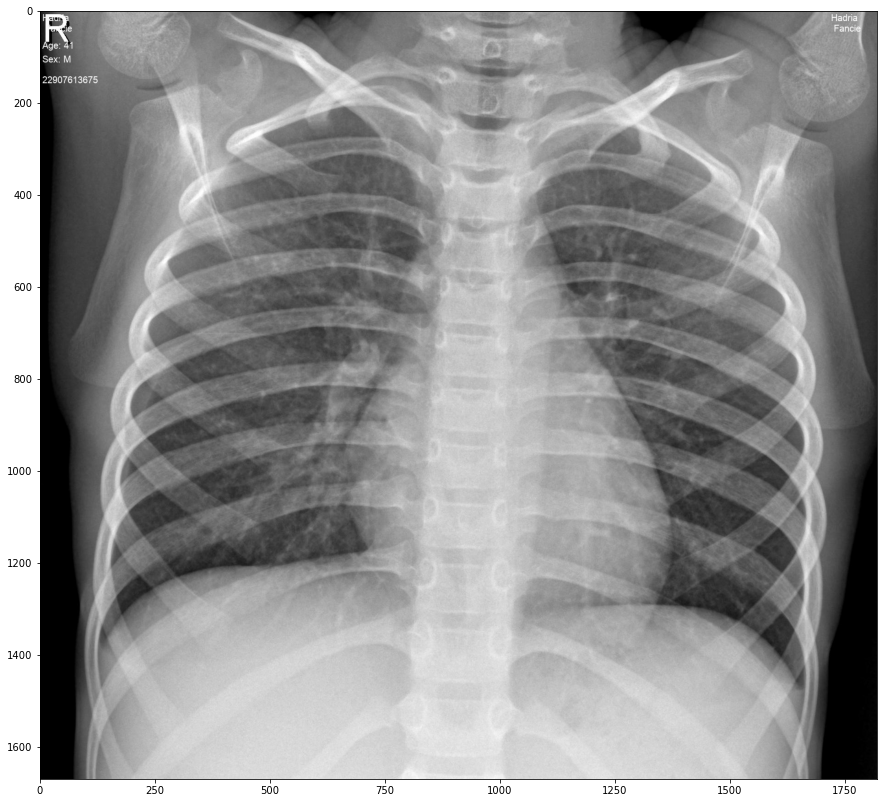

In [54]:
import matplotlib.image as implt
asdasa = path_lr/'IM-0401-0001.jpeg'
test = implt.imread(asdasa)
plt.figure(figsize=(15,15))
imgplot = plt.imshow(test)
#plt.show()

# create bboxes in coords.csv
## TODO
skrive om det meste...
annoterer i crappify i create_bbox_dset.ipynb


In [69]:
img_files = os.listdir(path_lr)
df_dataset = pd.DataFrame()
df_final = pd.DataFrame()
text = ""
for imgs in range(len(img_files)):
    img=str(path_lr) + '/' + str(img_files[imgs])
    large = cv2.imread(img)
    small = cv2.cvtColor(large, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

    _, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

    _, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    mask = np.zeros(bw.shape, dtype=np.uint8)

    bboxes=[]
    cat=[]
    for idx in range(len(contours)):
        x, y, w, h = cv2.boundingRect(contours[idx])
        bbox=[x,y,w,h]
        mask[y:y+h, x:x+w] = 0
        bboxes.append(bbox)
        cat.append(text)
        cv2.drawContours(mask, contours, idx, (255, 255, 255), 1)
        r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)



    df_dataset = df_dataset.append(pd.Series([img_files[imgs],bboxes, cat]), ignore_index=True)
    df_final = df_dataset.copy()
    df_final = df_dataset.rename(columns={0: 'file_name', 1: 'bbox', 2: 'lable'})


    #Patch Gcloud
    #path_tmp= Path('/home/jupyter/data/chest_xray/tmp_bbox_folder')

    #Path local MMIV
    path_tmp = Path('/home/fredrikmathisen/Documents/data/chest_xray/tmp_bbox_mask')

    cv2.imwrite(str(path_tmp/img_files[imgs]),mask)
    #np.savetxt('coords.csv', df_final, delimiter=',')

df_final.to_csv('coords.csv')

In [ ]:
findBboxes(path_lr)

In [12]:
#Path local MMIV
path_tmp = Path('/home/fredrikmathisen/Documents/data/chest_xray/tmp_bbox_mask')

#Path Gcloud
#path_tmp= Path('/home/jupyter/data/chest_xray/tmp_bbox_folder')
len(os.listdir(path_tmp))

5856

In [13]:
len(os.listdir(path_lr))

5856

In [59]:
test = pd.read_csv('coords.csv')

In [60]:
bbox_test = test.bbox.values

In [61]:
test.head()

,file_name,bbox,cat
0,person5_bacteria_15.jpeg,"[[5, 5, 48, 85.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
1,person1584_bacteria_4148.jpeg,"[[5, 5, 48, 68.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
2,person512_virus_1029.jpeg,"[[5, 5, 48, 87.0], [65, 5, 88, 85], [95, 5, 11...","['', '', '', '', '']"
3,person552_bacteria_2315.jpeg,"[[5, 5, 56, 86.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
4,person1449_virus_2476.jpeg,"[[5, 5, 56, 86.5], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"


In [62]:
type(test.bbox[0])

str

In [63]:
import ast

In [64]:
import pandas as pd
df_test = pd.read_csv('coords.csv')

In [65]:
df_test

,file_name,bbox,cat
0,person5_bacteria_15.jpeg,"[[5, 5, 48, 85.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
1,person1584_bacteria_4148.jpeg,"[[5, 5, 48, 68.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
2,person512_virus_1029.jpeg,"[[5, 5, 48, 87.0], [65, 5, 88, 85], [95, 5, 11...","['', '', '', '', '']"
3,person552_bacteria_2315.jpeg,"[[5, 5, 56, 86.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
4,person1449_virus_2476.jpeg,"[[5, 5, 56, 86.5], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
...,...,...,...
5851,IM-0661-0001.jpeg,"[[5, 5, 48, 91.5], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
5852,IM-0327-0001.jpeg,"[[5, 5, 48, 95.0], [65, 5, 88, 85], [95, 5, 11...","['', '', '', '', '']"
5853,IM-0187-0001.jpeg,"[[5, 5, 48, 92.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"
5854,NORMAL2-IM-0135-0001.jpeg,"[[5, 5, 48, 93.0], [65, 5, 88, 74], [95, 5, 11...","['', '', '', '', '']"


In [66]:
import matplotlib.patches as patches
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import ast

In [67]:
def plt_img_bbox():
    img = (path_lr/'NORMAL2-IM-0135-0001.jpeg')
    bbox_list = []
    bbox_list = ast.literal_eval(df_test.bbox) 
    #img= img.data[0,:,:]
    print(type(img))
    f, ax = plt.subplots(figsize=(20,20))
    for i in range(len(bbox_list)):
        bbox = bbox_list[i]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], color='r')
        ax.add_artist(rect)

    
    ax.imshow(io.imread(img))
        #ax.imshow(np.array(img))
    plt.xlabel('test')
    #plt.ylabel('asdjk')
    plt.show()

In [68]:
plt_img_bbox()

ValueError: malformed node or string: 0       [[5, 5, 48, 85.0], [65, 5, 88, 74], [95, 5, 11...
1       [[5, 5, 48, 68.0], [65, 5, 88, 74], [95, 5, 11...
2       [[5, 5, 48, 87.0], [65, 5, 88, 85], [95, 5, 11...
3       [[5, 5, 56, 86.0], [65, 5, 88, 74], [95, 5, 11...
4       [[5, 5, 56, 86.5], [65, 5, 88, 74], [95, 5, 11...
                              ...                        
5851    [[5, 5, 48, 91.5], [65, 5, 88, 74], [95, 5, 11...
5852    [[5, 5, 48, 95.0], [65, 5, 88, 85], [95, 5, 11...
5853    [[5, 5, 48, 92.0], [65, 5, 88, 74], [95, 5, 11...
5854    [[5, 5, 48, 93.0], [65, 5, 88, 74], [95, 5, 11...
5855    [[5, 5, 48, 88.0], [65, 5, 88, 85], [95, 5, 11...
Name: bbox, Length: 5856, dtype: object

In [69]:
bbox_list=[]
bbox_list = df_test.bbox.to_numpy()
for i in range(len(bbox_list[:20])):
    bbox = bbox_list[i]
    print(bbox)

[[5, 5, 48, 85.0], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1176, 48, 1331]]
[[5, 5, 48, 68.0], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 964, 48, 1085]]
[[5, 5, 48, 87.0], [65, 5, 88, 85], [95, 5, 114, 62], [140, 5, 159, 125], [5, 1124, 48, 1283]]
[[5, 5, 56, 86.0], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1132, 56, 1289]]
[[5, 5, 56, 86.5], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1090, 56, 1248]]
[[5, 5, 48, 93.5], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 892, 48, 1064]]
[[5, 5, 48, 70.5], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1144, 48, 1270]]
[[5, 5, 56, 72.5], [65, 5, 88, 85], [95, 5, 114, 62], [140, 5, 159, 125], [5, 1212, 56, 1342]]
[[5, 5, 48, 93.0], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1310, 48, 1481]]
[[5, 5, 48, 80.5], [65, 5, 88, 74], [95, 5, 114, 66], [140, 5, 159, 125], [5, 1592, 48, 1738]]
[[5, 5, 48, 97.0], [65, 5, 88, 74], [95, 5, 114, 66]